In [ ]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/enron_spam_data.csv")
df['Subject'] = df['Subject'].fillna("")
df['Message'] = df['Message'].fillna("")

# Encode labels
y = LabelEncoder().fit_transform(df['Spam/Ham'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df[['Subject', 'Message']],
    y, test_size=0.2,
    stratify=y,
    random_state=42)

preprocessor = ColumnTransformer([
    ('subject', CountVectorizer(), 'Subject'),
    ('message', CountVectorizer(), 'Message')
])

# Full pipeline with classifier
pipeline = make_pipeline(
    preprocessor,
    MultinomialNB()
)

# Train
pipeline.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('subject', CountVectorizer(),
                                                  'Subject'),
                                                 ('message', CountVectorizer(),
                                                  'Message')])),
                ('multinomialnb', MultinomialNB())])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv("/content/drive/MyDrive/enron_spam_data.csv")
df['Subject'] = df['Subject'].fillna("")
df['Message'] = df['Message'].fillna("")
df['Combined'] = df['Subject'] + " " + df['Message']
y = LabelEncoder().fit_transform(df['Spam/Ham'])

# Define feature sets
feature_sets = {
    "Subject Only": df[['Subject']],
    "Message Only": df[['Message']],
    "Subject + Message (Concatenated)": df[['Combined']],
    "Subject and Message (Separate)": df[['Subject', 'Message']]
}

# Define models
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVC": SVC(kernel='linear', probability=True)
}

# Store results
results = []

# Run experiments
for feat_name, X in feature_sets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

    for model_name, model in models.items():
        if feat_name == "Subject and Message (Separate)":
            preprocessor = ColumnTransformer([
                ('subject', CountVectorizer(), 'Subject'),
                ('message', CountVectorizer(), 'Message')
            ])
        else:
            col = X.columns[0]
            preprocessor = ColumnTransformer([
                ('text', CountVectorizer(), col)
            ])

        pipeline = make_pipeline(preprocessor, model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        results.append({
            "Model": model_name,
            "Feature Set": feat_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred)
        })

# Create DataFrame from results
results_df = pd.DataFrame(results)

# print results
results_df

,Model,Feature Set,Accuracy,Precision,Recall
0,MultinomialNB,Subject Only,0.975237,0.953637,1.0
1,LogisticRegression,Subject Only,0.997924,0.995941,1.0
2,SVC,Subject Only,0.998517,0.997097,1.0
3,MultinomialNB,Message Only,0.979834,0.961915,1.0
4,LogisticRegression,Message Only,0.999407,0.998837,1.0
5,SVC,Message Only,0.999407,0.998837,1.0
6,MultinomialNB,Subject + Message (Concatenated),0.986951,0.975021,1.0
7,LogisticRegression,Subject + Message (Concatenated),0.999407,0.998837,1.0
8,SVC,Subject + Message (Concatenated),0.999407,0.998837,1.0
9,MultinomialNB,Subject and Message (Separate),0.985765,0.972812,1.0


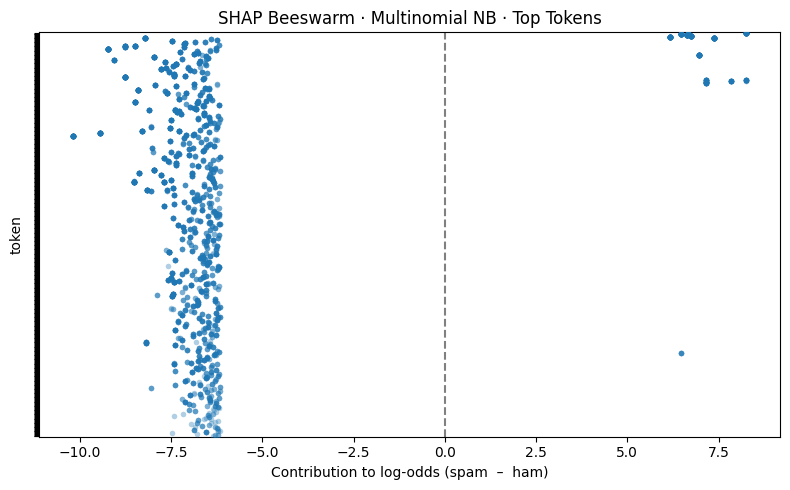

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# 1.  Load + build Combined column
df = pd.read_csv("/content/drive/MyDrive/enron_spam_data.csv")
df['Subject'] = df['Subject'].fillna('')
df['Message'] = df['Message'].fillna('')
df['Combined'] = df['Subject'] + ' ' + df['Message']
y  = LabelEncoder().fit_transform(df['Spam/Ham'])

# 2.  Train NB on Combined text
X_train, X_test, y_train, y_test = train_test_split(
    df['Combined'], y, test_size=0.20, stratify=y, random_state=42
)
vec  = CountVectorizer(stop_words='english', min_df=2)
X_tv = vec.fit_transform(X_train)
nb   = MultinomialNB(alpha=1.0).fit(X_tv, y_train)

# 3.  Token-level “SHAP” for NB = log P(token|spam) – log P(token|ham)
log_ratio   = nb.feature_log_prob_[1] - nb.feature_log_prob_[0]
feat_names  = np.array(vec.get_feature_names_out())

# 4.  Build dot cloud for (at most) 300 random test e-mails
sample_txt = X_test.sample(300, random_state=42)
tokens, vals = [], []
for txt in sample_txt:
    for tok in set(re.findall(r"\b\w+\b", txt.lower())):
        idx = vec.vocabulary_.get(tok)
        if idx is not None:
            tokens.append(tok)
            vals.append(log_ratio[idx])

shap_df = pd.DataFrame({"token": tokens, "value": vals})

# 5.  Keep the top tokens with largest |mean SHAP|
top = shap_df.groupby('token')['value'].apply(lambda s: np.abs(s).mean())\
               .nlargest(500).index
shap_top = shap_df[shap_df.token.isin(top)]

# 6.  Beeswarm-style plot
plt.figure(figsize=(8,5))
sns.stripplot(data=shap_top, x='value', y='token',
              jitter=True, alpha=0.35, size=4)
plt.axvline(0, ls='--', c='grey')
plt.title("SHAP Beeswarm · Multinomial NB · Top Tokens")
plt.xlabel("Contribution to log-odds (spam  –  ham)")
ax = plt.gca()
ax.set_yticklabels([])
plt.tight_layout(); plt.show()


NB’s log-probability is the sum of those per-token terms.

Shapley theory says the contribution of each additive term is just the term itself.

So we can skip the expensive game-theoretic sampling that the shap library does for non-additive models and calculate
𝜙
ϕ directly from the fitted model parameters.

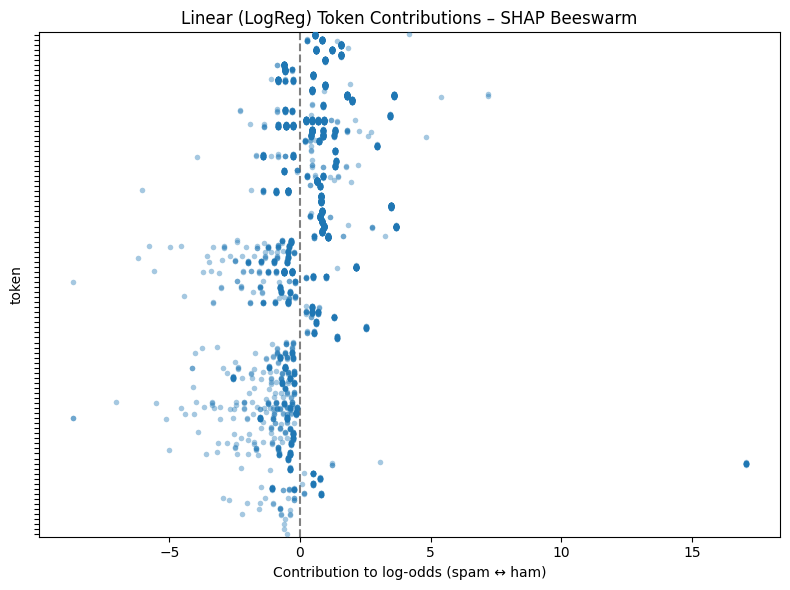

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Logistic Regression · Token-level SHAP-style Beeswarm (Top 30 tokens)
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# 1️⃣  Load CSV from your Drive
csv_path = "/content/drive/MyDrive/enron_spam_data.csv"      # ← update if needed
df = pd.read_csv(csv_path)

# 2️⃣  Build combined text column + labels
df['Subject'] = df['Subject'].fillna('')
df['Message'] = df['Message'].fillna('')
df['Combined'] = df['Subject'] + ' ' + df['Message']
y = LabelEncoder().fit_transform(df['Spam/Ham'])              # 1 = spam, 0 = ham

# 3️⃣  Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df[['Combined']], y, test_size=0.20, stratify=y, random_state=42
)

# 4️⃣  Text vectoriser + single-process Logistic Regression
preproc = ColumnTransformer(
    [('text', CountVectorizer(stop_words='english', min_df=2), 'Combined')]
)
pipe = make_pipeline(preproc,
                     LogisticRegression(max_iter=1000, n_jobs=1))
pipe.fit(X_train, y_train)

# 5️⃣  Extract vectoriser + coeffs
vec   = pipe.named_steps['columntransformer'].named_transformers_['text']
coef  = pipe.named_steps['logisticregression'].coef_[0]        # shape (n_features,)
tokens = np.array(vec.get_feature_names_out())

# 6️⃣  Compute token contributions for 400 random test e-mails
sample_idx   = X_test.sample(400, random_state=42).index
X_sample_vec = vec.transform(df.loc[sample_idx, 'Combined'])
contrib_mat  = X_sample_vec.multiply(coef)                     # sparse CSR

rows = []
for i in range(contrib_mat.shape[0]):
    row = contrib_mat.getrow(i)
    for j in row.nonzero()[1]:
        rows.append({'token': tokens[j], 'value': row[0, j]})

shap_df = pd.DataFrame(rows)

# 7️⃣  Select tokens with highest global importance  (mean |value|)
top_tokens = (shap_df.groupby('token')['value']
              .apply(lambda s: np.abs(s).mean())
              .nlargest(100).index)
plot_df = shap_df[shap_df['token'].isin(top_tokens)]

# 8️⃣  Beeswarm-style plot
plt.figure(figsize=(8, 6))
sns.stripplot(data=plot_df, x='value', y='token',
              jitter=0.3, alpha=0.4, size=4)
plt.axvline(0, color='grey', ls='--')
plt.title("Linear (LogReg) Token Contributions – SHAP Beeswarm")
plt.xlabel("Contribution to log-odds (spam ↔ ham)")
ax = plt.gca()
ax.set_yticklabels([])
plt.tight_layout(); plt.show()


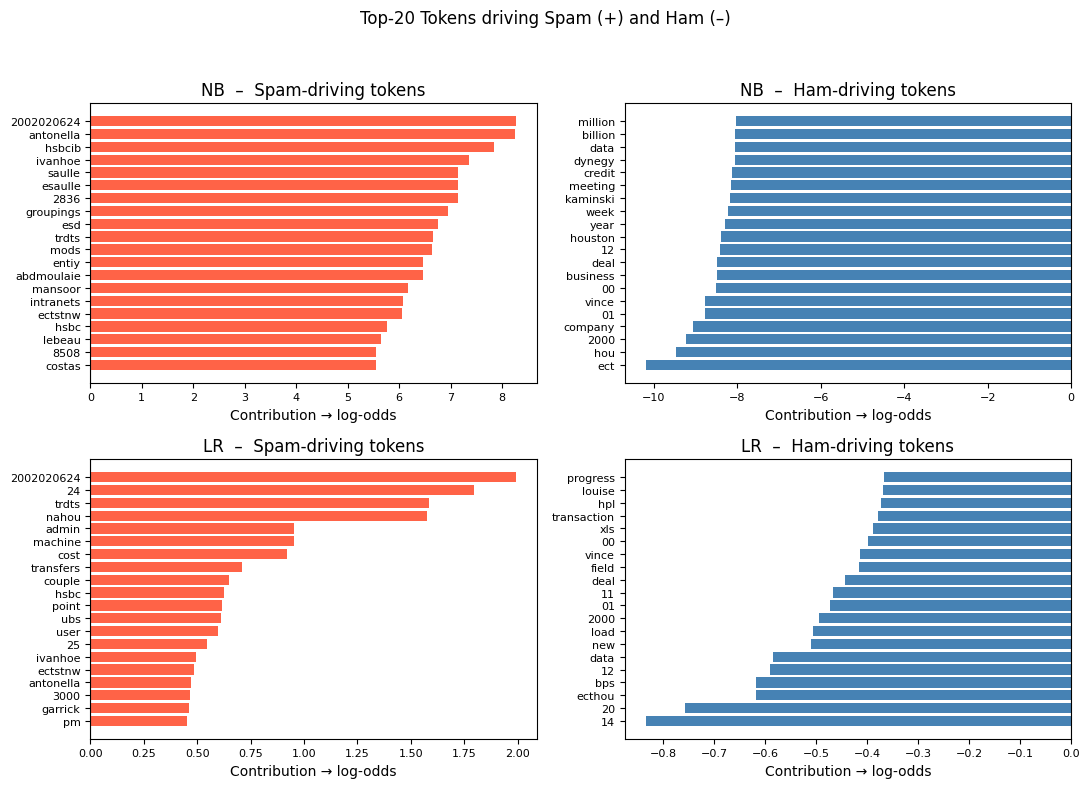

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

df = pd.read_csv("/content/drive/MyDrive/enron_spam_data.csv")
df['Subject']  = df['Subject'].fillna('')
df['Message']  = df['Message'].fillna('')
df['Combined'] = df['Subject'] + ' ' + df['Message']
y  = LabelEncoder().fit_transform(df['Spam/Ham'])
X_train, X_test, y_train, y_test = train_test_split(
    df[['Combined']], y, test_size=0.20, stratify=y, random_state=42
)
vec = CountVectorizer(stop_words='english', min_df=2)
preproc = ColumnTransformer([('text', vec, 'Combined')])
nb_pipe = make_pipeline(preproc, MultinomialNB())
lr_pipe = make_pipeline(preproc, LogisticRegression(max_iter=1000, n_jobs=1))
nb_pipe.fit(X_train, y_train)
lr_pipe.fit(X_train, y_train)
vec           = nb_pipe.named_steps['columntransformer'].named_transformers_['text']
tokens        = np.array(vec.get_feature_names_out())
nb_log_ratio  = nb_pipe.named_steps['multinomialnb'].feature_log_prob_[1] \
              - nb_pipe.named_steps['multinomialnb'].feature_log_prob_[0]
lr_coef       = lr_pipe.named_steps['logisticregression'].coef_[0]

def barplot(vals, title, ax, color):
    top_pos   = np.argsort(vals)[-20:]
    top_neg   = np.argsort(vals)[:20]
    ax.barh(tokens[top_pos],  vals[top_pos],  color=color)
    ax.set_title(title)
    ax.set_xlabel("Contribution → log-odds")
    ax.axvline(0, color='grey', lw=0.8)
    ax.tick_params(labelsize=8)

def barplot_neg(vals, title, ax, color):
    top_neg   = np.argsort(vals)[:20]
    ax.barh(tokens[top_neg],  vals[top_neg],  color=color)
    ax.set_title(title)
    ax.set_xlabel("Contribution → log-odds")
    ax.axvline(0, color='grey', lw=0.8)
    ax.tick_params(labelsize=8)

fig, axes = plt.subplots(2, 2, figsize=(11, 8))
plt.suptitle("Top-20 Tokens driving Spam (+) and Ham (–)")

barplot(nb_log_ratio,        "NB  –  Spam-driving tokens", axes[0,0], 'tomato')
barplot_neg(nb_log_ratio,    "NB  –  Ham-driving tokens",  axes[0,1], 'steelblue')

barplot(lr_coef,             "LR  –  Spam-driving tokens", axes[1,0], 'tomato')
barplot_neg(lr_coef,         "LR  –  Ham-driving tokens",  axes[1,1], 'steelblue')

plt.tight_layout(rect=[0,0,1,0.95]); plt.show()


Mounted at /content/drive
